In [1]:
path_model_outputs = r'C:\Data\bhima_Input_mainCWatM\Output\\'
path_observed_data = 'C:/GitHub/FUSE/Data_forNotebooks/WaterTable/'
Inputs_file_modflow = r'C:\Data\bhima_Input_mainCWatM\Modflow\modflow_inputs\Bhima_MF6\\'

# Groundwater

Presenting simulation results related to groundwater alongside observations. 

✔️ update the file paths above <br>
⏩ Run with the black and white fast-forward icon above.

### Groundwater depth

CWatM is coupled with the groundwater model Modflow. Water flows into the subsurface through four processes:
1. through the soil layer, 
2. through riverbeds, 
3. through preferential root paths, and 
4. through reservoir & canal leakage. 

Water flows out of the subsurface through three processes: 
1. pumping, 
2. baseflow into rivers, and 
3. capillarly rise into the soil.

In [2]:
## Importing Python modules
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xlrd
from datetime import datetime
import rasterio

import plotly.express as px

plt.rcParams['figure.figsize'] = [14, 8.0]


## Importing paths
# Where CWATM results are stored
#path_model_outputs = 'C:/CWatM_output/' #_Examples/CWatM_output_09Sept_GabConductivity/'
# Where observed data are stored

#path_observed_data = 'C:\GitHub\FUSE\Data_forNotebooks\WaterTable/'
# Where ModFlow inputs for the grid are stored


## Loading files containing basin grid information
#Size = np.loadtxt(Inputs_file_modflow + 'UB_limits.txt')
#res_ModFlow = (Size[1]-Size[0])/(Size[5]-1)  # in [m]

#basin = np.loadtxt(Inputs_file_modflow + 'Basin_limits.txt')

# Map dimensions
#ncol = int((Size[1]-Size[0])/res_ModFlow)+1 
#nrow = int(abs((Size[3]-Size[2])/res_ModFlow)+1)
#nrow=566 #MS
         # ModFlow format

In [3]:
## Upload simulated maps from the netcdf files
#ds = xr.open_dataset(path_model_outputs + 'modflowWaterLevel_monthend.nc')
ds = xr.open_dataset(path_model_outputs + 'modflow_head_adjusted_monthend.nc')

#GWTable_ModFlow = ds['modflowWaterLevel_monthend'][:].data # Array of water levels [m] (time, nrow, ncol)
GWTable_ModFlow = ds['modflow_head_adjusted_monthend'][:].data # Array of water levels [m] (time, nrow, ncol)
Time_ModFlow = ds['time'][:].data
Time_ModFlowV2 = (Time_ModFlow - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
Time_ModFlowV3 = np.zeros(len(Time_ModFlow))
for it in range(len(Time_ModFlow)):
    dd = datetime.utcfromtimestamp(Time_ModFlowV2[it])
    Time_ModFlowV3[it] = dd.toordinal()
ds.close()


ncol = np.shape(GWTable_ModFlow)[2]
nrow = np.shape(GWTable_ModFlow)[1]
#Size = [322283, 2150401]
res_ModFlow = 500 #changeResolution
#Size = [304654.5-res_ModFlow/2, 2157367.688+res_ModFlow/2]
#Size = [304654.5, 2157367.688] #250m
Size = [304654.5, 2157617.688] #500m
print('ModFlow resolution is : ', res_ModFlow, ' meters')

with rasterio.open(Inputs_file_modflow + 'modflow_basin.tif', 'r') as src:
    basin = src.read(1).astype(np.bool)  # read in as 2-dimensional array (nrows, ncols).
basin = basin * 1  # to have 0 and 1 instead of False and True

#basin = basin.reshape(nrow,ncol)     

## Upload topography defined in ModFlow and soil thickness defined in CWATM
ds = xr.open_dataset(path_model_outputs + 'modflowtotalSoilThickness_totalend.nc')
Soil_thickness = ds['modflowtotalSoilThickness_totalend'][:].data 
ds.close()

with rasterio.open(Inputs_file_modflow + 'elevation_modflow.tif', 'r') as src:
    topography = src.read(1).astype(np.float32)
with rasterio.open(Inputs_file_modflow + 'modlfow_river_percentage.tif', 'r') as src:
    modflow_riverpercentage = src.read(1).astype(np.float32)

#! Top = np.loadtxt(Inputs_file_modflow + 'Topo.txt')
#! Topography_ModFlow = Top.reshape(nrow,ncol) + Soil_thickness # We need to add soil thickness to compare WTD

#Soil_thickness = np.where(lakeArea_modflow <= 0, np.where(modflow_riverpercentage > 0, 1.5, Soil_thickness), Soil_thickness)
Topography_ModFlow = topography - Soil_thickness

ModFlow resolution is :  500  meters


<ipython-input-3-5fd0ddb5eac8>:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  Time_ModFlowV2 = (Time_ModFlow - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-3-5fd0ddb5eac8>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  basin = src.read(1).astype(np.bool)  # read in as 2-dimensional array (nrows, ncols).


## Plot the time-average simulated groundwater map and the total groundwater storage evolution

<ipython-input-4-c40caf21cc8a>:7: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(GWTable_ModFlow[-2*12:],0)-np.nanmean(GWTable_ModFlow[0:2*12],0)), cmap=cmap,
<ipython-input-4-c40caf21cc8a>:18: RuntimeWarning: Mean of empty slice
  plt.plot_date(Time_ModFlowV3, np.nanmean(np.nanmean(Topography_ModFlow - GWTable_ModFlow,1),1),
<ipython-input-4-c40caf21cc8a>:27: RuntimeWarning: Mean of empty slice
  MeanWaterTable = np.nanmean(GWTable_ModFlow,0)


-0.0037841797
15.477905


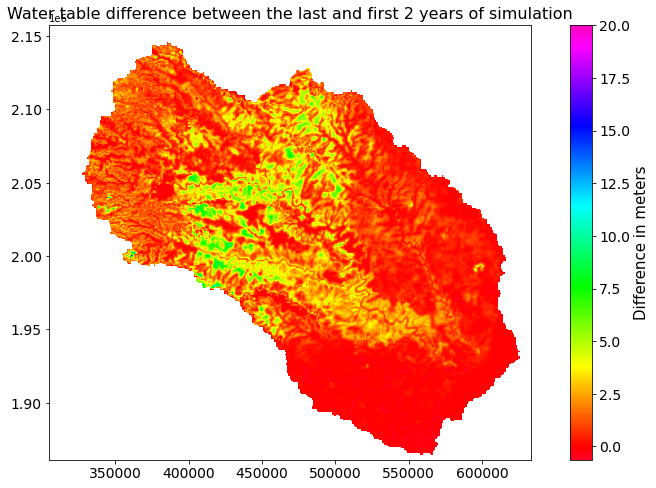

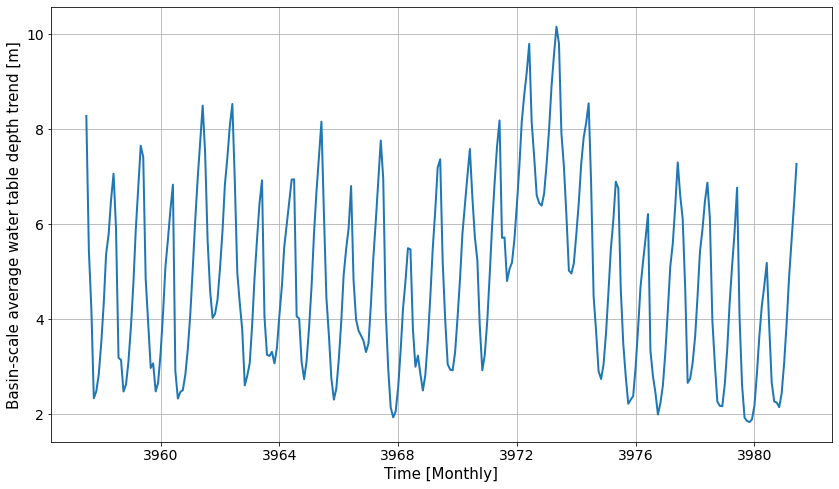

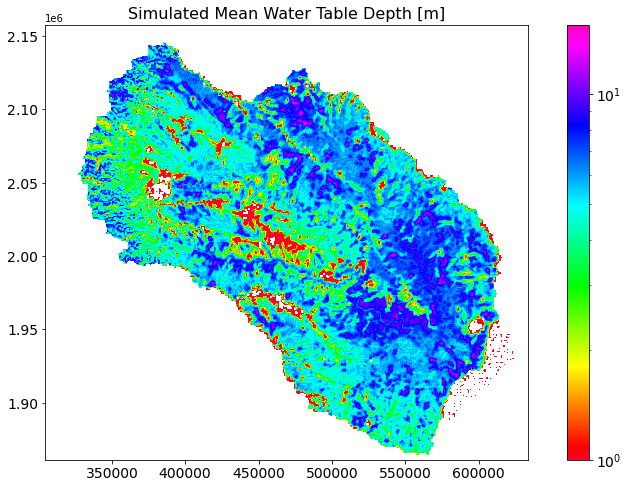

In [4]:
## Plot the water balance trend in Groundwater:
#extent = (float(Size[0])-res_ModFlow/2, float(Size[1])+res_ModFlow/2, float(Size[2])+res_ModFlow/2, float(Size[3])-res_ModFlow/2)
extent = (Size[0], Size[0]+ncol*res_ModFlow, Size[1], Size[1]-nrow*res_ModFlow)
cmap = plt.cm.gist_rainbow
fig1 = plt.figure()
# as we record water table at the end of each month 2*12 is equal to 2 yrs
plt.imshow((np.nanmean(GWTable_ModFlow[-2*12:],0)-np.nanmean(GWTable_ModFlow[0:2*12],0)), cmap=cmap,
           extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.title('Water table difference between the last and first 2 years of simulation', fontsize=16)
cb = plt.colorbar()
cb.set_label('Difference in meters', fontsize=15)
cb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig2 = plt.figure()
plt.plot_date(Time_ModFlowV3, np.nanmean(np.nanmean(Topography_ModFlow - GWTable_ModFlow,1),1),
             linestyle='solid', marker=None, linewidth=2)
plt.ylabel('Basin-scale average water table depth trend [m]', fontsize=15)
plt.xlabel('Time [Monthly]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

## Computing the mean map of simulated water table and water table depth
MeanWaterTable = np.nanmean(GWTable_ModFlow,0)
MeanWaterTableDepth = Topography_ModFlow - MeanWaterTable

# Print the map
fig3 = plt.figure()
plt.imshow(MeanWaterTableDepth, norm=LogNorm(vmin=max(np.nanmin(MeanWaterTableDepth),1), vmax=np.nanmax(MeanWaterTableDepth)),
           cmap=cmap, extent=extent, origin='lower')
#plt.imshow(MeanWaterTableDepth, cmap=cmap, extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.title('Simulated Mean Water Table Depth [m]', fontsize=16)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

print(np.nanmin(MeanWaterTableDepth))
print(np.nanmax(MeanWaterTableDepth))

## Uploading observed water table and find the ModFlow coordinates of each borehole

In [ ]:
## Upload observed water table depth
Measured_watertabledepth = np.zeros((382,21)) # 2D array containing measured data: 382 boreholes for Bhima, 21 dates
wb = xlrd.open_workbook(path_observed_data + "UB_GW_DataProcessed.xls")
sh = wb.sheet_by_name(u'Sheet1')
for il in range(np.shape(Measured_watertabledepth)[0]):
    for ic in range(np.shape(Measured_watertabledepth)[1]):
        val=sh.row_values(il+1)[ic]
        if val == '':
            Measured_watertabledepth[il][ic] = np.nan
        else:
            Measured_watertabledepth[il][ic] = val

## Upload associated dates
Measured_dates = np.zeros(np.shape(Measured_watertabledepth)[1])
for ic in range(np.shape(Measured_watertabledepth)[1]):
    Measured_dates[ic] = datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[ic]) - 2
    

    
## Upload coordinates, water table and topography of each borehole
x_GW = np.loadtxt(path_observed_data + 'GW_level_x.txt')
y_GW = np.loadtxt(path_observed_data + 'GW_level_y.txt')
z_GW = np.loadtxt(path_observed_data + 'GW_level_z.txt')

## List containing only boreholes in the basin and not too close from the basin limit (at least 1 cell)
x_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])   # Boreholes out of the basin will be removed after            
y_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0]) 
z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])
wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                 # Observed water table
wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                # Observed water table depth
Sim_wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))            # Simulated water table
Sim_wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))             # Simulated water table depth
Sim_z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])              # Altitude of the cell in the model (differnt from borehole information)

## Preparing data for the linear interpolation inside the grid
X = np.arange(0, ncol)
Y = np.arange(0, nrow)
X,Y = np.meshgrid(X,Y)
points = np.array( (X.flatten(), Y.flatten()) ).T

# We assume the period April 1997 to April 2007 is included in the model
# For each date of observation, we look for the closer date of simulation
Index_measured_date = np.zeros(len(Measured_dates))
for it in range(len(Measured_dates)):
    Index_measured_date[it] = np.argmin(np.abs(Time_ModFlowV3-Measured_dates[it])) # index corresponding to the closer date

valuesWaterTable = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))
valuesWaterTableDepth = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))

for it in range(len(Measured_dates)): # For each measured time
    PiezoMap = GWTable_ModFlow[int(Index_measured_date[it])]
    PiezoDepthMap = Topography_ModFlow - GWTable_ModFlow[int(Index_measured_date[it])]
    valuesWaterTable[it] = PiezoMap.flatten()           # Map of the simulated water table for each date of observation
    valuesWaterTableDepth[it] = PiezoDepthMap.flatten() # Map of the simulated water table depth for each date of observation

valuesTopography_ModFlow = Topography_ModFlow.flatten() # Map of the topography defined in ModFlow

som=0
for pz in range(len(x_GW)): # For each monitoring borehole

    # Find the corresponding column and row where the borehole is located
    colPz = int(round((x_GW[pz] - float(Size[0])) / res_ModFlow))
    rowPz = int(round((float(Size[1]) - y_GW[pz]) / res_ModFlow))
    
    #colPz = int(round((x_GW[pz]-float(Size[0]))/res_ModFlow))
    #rowPz = int(round((float(Size[2])-y_GW[pz])/res_ModFlow))

    if colPz>0 and rowPz>0 and colPz<ncol and rowPz<nrow:       # If the borehole is in the model
        if basin[rowPz][colPz] == 1:         # If the borehole is in the basin

            # Interpolating the simulated value as observation points are not in the cells center
            X0 = (x_GW[pz] - float(Size[0])) / res_ModFlow
            Y0 = (float(Size[1]) - y_GW[pz]) / res_ModFlow
            
            close_points = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 15] # all points at distance < 4 cell units
            # If the cell is not too close from an inactive cell (= too close from the basin limits)
            if 0 not in basin[close_points[:,1],close_points[:,0]]:
                som=som+1

                x_GW_bhima[som-1] = x_GW[pz]
                y_GW_bhima[som-1] = y_GW[pz]
                z_GW_bhima[som-1] = z_GW[pz]
                wtd_GW_bhima[som-1][:] = Measured_watertabledepth[pz]               # Each column corresponds to a specific date between April 1997 and April 2007
                wt_GW_bhima[som-1][:] = z_GW[pz]-Measured_watertabledepth[pz]

                # As interpolation seems to long for the Bhima, we create a new grid closer from the observation point
                points2 = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                
                # Interpolation
                valuesTopography_ModFlow2 = valuesTopography_ModFlow[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                Val = griddata(points2, valuesTopography_ModFlow2, (X0,Y0), method='linear' )
                Sim_z_GW_bhima[som-1] = Val

                compt=0
                for ii in range(len(Measured_dates)): # For each measured time

                    valuesWaterTableDepth2 = valuesWaterTableDepth[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    valuesWaterTable2 = valuesWaterTable[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    Val = griddata(points2, valuesWaterTableDepth2, (X0,Y0), method='linear' )
                    Sim_wtd_GW_bhima[som-1][compt] = Val
                    Val = griddata(points2, valuesWaterTable2, (X0,Y0), method='linear' )
                    Sim_wt_GW_bhima[som-1][compt] = Val
                    compt+=1

print('Number of boreholes in the Bhima basin : ', np.shape(Measured_watertabledepth)[0])            
print('Number of boreholes used for water table comparison in the selected basin : ', som)

## Keep only boreholes inside the basin and not too close from the basin limits
x_GW_bhima = x_GW_bhima[:som]       
y_GW_bhima = y_GW_bhima[:som] 
z_GW_bhima = z_GW_bhima[:som] 
wt_GW_bhima = wt_GW_bhima[:som] 
wtd_GW_bhima = wtd_GW_bhima[:som] 
Sim_wtd_GW_bhima = Sim_wtd_GW_bhima[:som] 
Sim_wt_GW_bhima = Sim_wt_GW_bhima[:som] 
Sim_z_GW_bhima = Sim_z_GW_bhima[:som]


## Computing criteria for the time average

In [ ]:
## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
## MEAN VALUE ## -> compute a global RMS error, normalized difference, normalized RMSE and coefficient of correlation

## Time averaging of simulate and observed data
Mean_Sim_wt_GW_bhima = np.mean(Sim_wt_GW_bhima,1)
Mean_Sim_wtd_GW_bhima = np.mean(Sim_wtd_GW_bhima,1)
Mean_wt_GW_bhima = np.nanmean(wt_GW_bhima,1)    # nanmean is used because there are nan values in observed data
Mean_wtd_GW_bhima = np.nanmean(wtd_GW_bhima,1)

## Correlation COEFFICIENT
PearsonWaterTable = np.corrcoef(Mean_wt_GW_bhima, Mean_Sim_wt_GW_bhima)    
CorrWaterTable = PearsonWaterTable[0][1]
PearsonWaterTableDepth = np.corrcoef(Mean_wtd_GW_bhima, Mean_Sim_wtd_GW_bhima)    
CorrWaterTableDepth = PearsonWaterTableDepth[0][1]

## MEAN Normalize water table depth difference
average_Norm_diffDepth = np.nanmean(np.abs(Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100) # In percentage
Norm_diffDepth = (Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100 # In percentage
# The 'average' criteria is always positive, we add - to indicate if simulated water levels are too deep
average_Norm_diffDepth = average_Norm_diffDepth * (np.nanmean(Norm_diffDepth)/np.abs(np.nanmean(Norm_diffDepth)))

## MEAN Root mean square error
RmseWaterTable = np.sqrt(np.sum((Mean_wt_GW_bhima - Mean_Sim_wt_GW_bhima)**2) / len(Mean_wt_GW_bhima))
RmseWaterTableDepth = np.sqrt(np.sum((Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)**2) / len(Mean_wtd_GW_bhima))

## MEAN normalized Root mean square error
RmseWaterTable_norm = RmseWaterTable/np.std(Mean_wt_GW_bhima)
RmseWaterTableDepth_norm = RmseWaterTableDepth/np.std(Mean_wtd_GW_bhima)


## Plot of the time average comparison

In [ ]:
## Plot the basin map with scatter showing discrepancy in Water Table Depth
fig4 = plt.figure()
Topo = np.copy(Topography_ModFlow)
Topo[np.isnan(MeanWaterTable)] = np.nan
plt.imshow(Topo, cmap='copper', alpha=0.7, extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.title('Mean Water Table Depth Comparison at several boreholes', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(x_GW_bhima, y_GW_bhima, c=Norm_diffDepth, s=50)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.set_label('Water Table Depth Difference [%]\n(<0 if too deep)', fontsize=15)
cb.ax.tick_params(labelsize=14)



## Plot time-averaged results for water table comparison
fig5 = plt.figure()
# Print the perfect line 1/1
plt.plot([np.nanmin(Mean_wt_GW_bhima),np.nanmax(Mean_wt_GW_bhima)],[np.nanmin(Mean_wt_GW_bhima),np.nanmax(Mean_wt_GW_bhima)], linestyle='solid', linewidth=2, marker=None)
label1 = ' Pearson correlation coefficient : ' + str(round(CorrWaterTable*100)/100) + '\n RMSE [m] : ' + str(round(RmseWaterTable*100)/100) + '\n Normalized RMSE: ' + str(round(RmseWaterTable_norm*100)/100) 
plt.plot(Mean_wt_GW_bhima, Mean_Sim_wt_GW_bhima, marker='o', markersize=10, color='r', linestyle='')
plt.text(np.nanmin(Mean_wt_GW_bhima), np.nanmax(Mean_wt_GW_bhima)-100, label1, fontsize=15,
        bbox=dict(facecolor='white', alpha=0.5), linespacing=2)
plt.xlabel('Measured Mean Water Table [m]', fontsize=16)
plt.ylabel('Simulated Mean Water Table [m]', fontsize= 16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


import plotly.graph_objects as go
fig = go.Figure()
    
fig.add_trace(go.Scatter(y=Mean_Sim_wt_GW_bhima,
                         x=Mean_wt_GW_bhima,
                         mode = 'markers',
                name='Observed'))
fig.add_trace(go.Scatter(x=[np.nanmin(Mean_wt_GW_bhima),np.nanmax(Mean_wt_GW_bhima)],
                         y=[np.nanmin(Mean_wt_GW_bhima),np.nanmax(Mean_wt_GW_bhima)],
                         mode = 'lines'
                             
))



fig.update_layout(title= 'Water table fluctuations (average across all wells)',
                   xaxis_title='Measured time-averaged water table depth [m]',
                   yaxis_title='Simulated time-averaged water table depth [m]', template='plotly_dark')
 
fig.show()

## Plot time-averaged results for water table depth comparison
fig6 = plt.figure()
# Print the perfect line 1/1
plt.plot([np.nanmin(Mean_wtd_GW_bhima),np.nanmax(Mean_wtd_GW_bhima)],[np.nanmin(Mean_wtd_GW_bhima),np.nanmax(Mean_wtd_GW_bhima)], linestyle='solid', linewidth=2, marker=None)
label2 = ' Mean difference [%] : ' + str(round(average_Norm_diffDepth*100)/100) + '\n Pearson correlation coefficient : ' + str(round(CorrWaterTableDepth*100)/100) + '\n RMSE [m] : ' + str(round(RmseWaterTableDepth*100)/100) + '\n Normalized RMSE: ' + str(round(RmseWaterTableDepth_norm*100)/100) 
plt.plot(Mean_wtd_GW_bhima, Mean_Sim_wtd_GW_bhima, marker='o', markersize=10, color='r', linestyle='')
plt.text(np.nanmin(Mean_wtd_GW_bhima), np.nanmax(Mean_Sim_wtd_GW_bhima)-30, label2, fontsize=15,
        bbox=dict(facecolor='white', alpha=0.5), linespacing=2)
plt.xlabel('Measured time-averaged water table depth [m]', fontsize= 16)
plt.ylabel('Simulated time-averaged water table depth [m]', fontsize= 16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


## Comparing Water Table fluctuations

In [ ]:
## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
## TRANSIENT VALUE ## -> compute nRMSE for each borehole, after subtracting the mean as the mean behavior is already compared by other criteria

## Computing normalized root mean square error on water table fluctuations for each borehole
Transient_nRMSE = np.zeros(len(wt_GW_bhima))
for ib in range(len(wt_GW_bhima)): # For each borehole
    Transient_nRMSE[ib] = np.sqrt(np.nansum((wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])-(Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])))**2) / np.count_nonzero(~np.isnan(wt_GW_bhima[ib]))) / np.nanstd(wt_GW_bhima[ib])

## Mean value of the nRMSE in transient
wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
Sim_wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
for ib in range(len(wt_GW_bhima)): # for each borehole, remove the mean
    wt_fluctu[ib] = wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])
    Sim_wt_fluctu[ib] = Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])

Average_transient_nRMSE = np.sqrt(np.nansum((np.nanmean(wt_fluctu, 0)-np.nanmean(Sim_wt_fluctu, 0))**2) / np.count_nonzero(~np.isnan(np.nanmean(wt_fluctu, 0)))) / np.nanstd(np.nanmean(wt_fluctu, 0))

# Optimize curve fitting with a sinus, to compare the seasonal amplitude
from scipy import optimize
from scipy import signal

x_data = np.linspace(1,len(Measured_dates),len(Measured_dates))
periode_annuel = 12 # Because we are at monthly timestep

def sin_func(x, ampli, phase):
    ff = np.abs(ampli) * np.sin(2*np.pi/periode_annuel * x + phase)
    return ff

params_mean_wt_fluctu, params_covariance = optimize.curve_fit(sin_func, x_data, signal.detrend(np.nanmean(wt_fluctu, 0)), p0=[1, 5])
params_mean_Sim_wt_fluctu, params_covariance = optimize.curve_fit(sin_func, x_data, signal.detrend(np.nanmean(Sim_wt_fluctu, 0)), p0=[1, 5])
seasonal_amplitude_difference = -2 * (params_mean_wt_fluctu[0]-params_mean_Sim_wt_fluctu[0])

Average_transient_nRMSE = Average_transient_nRMSE * (seasonal_amplitude_difference/np.abs(seasonal_amplitude_difference))
# thus the critria is > 0 when the simulated fluctuations are not high

## Plot the Transient_nRMSE in function of normalized difference between water table depth
fig7 = plt.figure()
plt.scatter(Norm_diffDepth, Transient_nRMSE, marker='o', s=30)
plt.xlabel('Normalized time-averaged water table depth difference [%]', fontsize= 16)
plt.ylabel('Normalized root mean square error on water table fluctuations', fontsize= 16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


## Plot the best 3 boreholes for water table fluctuations
sorted_Transient_nRMSE = np.argsort(Transient_nRMSE)
for i in range(10):
    plt.figure()
    plt.plot_date(Measured_dates, wt_GW_bhima[sorted_Transient_nRMSE[i]]-np.nanmean(wt_GW_bhima[sorted_Transient_nRMSE[i]]), label='Observed water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='k')
    plt.plot_date(Measured_dates, Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]]-np.nanmean(Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]]), label='Simulated water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='r')
    plt.grid()
    plt.legend(fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time [monthly]', fontsize=14)
    plt.ylabel('Water Table fluctuations (best boreholes)', fontsize=14)
    txt_title = 'Transient nRMSE on Water Table Fluctuations : ' + str(np.round(Transient_nRMSE[sorted_Transient_nRMSE[i]]*100)/100)
    plt.title(txt_title, fontsize=15)


In [ ]:
## Plot the mean storage fluctuations at boreholes,

# Plot the results from the model and from the observed data
fig11 = plt.figure()
plt.plot_date(Measured_dates, np.nanmean(wt_fluctu, 0), label='Observed water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='k')
plt.plot_date(Measured_dates, np.nanmean(Sim_wt_fluctu, 0), label='Simulated water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='r')
plt.grid()
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time [monthly]', fontsize=14)
plt.ylabel('Water Table fluctuations (average across all boreholes) [m]', fontsize=14)
txt_title = 'Normalized root mean square error on water table fluctuations (average across all boreholes) : ' + str(np.round(Average_transient_nRMSE*100)/100)
plt.title(txt_title, fontsize=15)
from datetime import datetime
import plotly.graph_objects as go
fig = go.Figure()
Measured_dates_ex = []
for ic in range(np.shape(Measured_watertabledepth)[1]):
    proper_date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[ic]) - 2)
    Measured_dates_ex.append(proper_date)
    
fig.add_trace(go.Scatter(y=np.nanmean(wt_fluctu, 0),
                         x=Measured_dates_ex,
                mode='lines',
                name='Observed'))

fig.add_trace(go.Scatter(y=np.nanmean(Sim_wt_fluctu, 0),
                         x=Measured_dates_ex,
                mode='lines',
                name='Simulated'))

fig.update_layout(title= 'Water table fluctuations (average across all wells)',
                   xaxis_title='Month',
                   yaxis_title='Water Table fluctuations [m]', template='plotly_dark')
 
fig.show()

In [ ]:
import matplotlib.backends.backend_pdf
print(plt.figure().number)
pdf = matplotlib.backends.backend_pdf.PdfPages(path_model_outputs + r"\GW_output.pdf")
pdf.savefig(fig1)
pdf.savefig(fig2)
pdf.savefig(fig3)
pdf.savefig(fig4)
pdf.savefig(fig5)
pdf.savefig(fig6)
pdf.savefig(fig7)
pdf.savefig(fig11)
pdf.close()

In [ ]:
"""
for i in range(25):
    plt.figure()
    plt.plot_date(Measured_dates, wt_GW_bhima[sorted_Transient_nRMSE[i]], label='Observed water table [m]', linestyle='solid', marker=None, linewidth=2, color='k')
    plt.plot_date(Measured_dates, Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]], label='Simulated water table [m]', linestyle='solid', marker=None, linewidth=2, color='r')
    plt.grid()
    plt.legend(fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time [monthly]', fontsize=14)
    plt.ylabel('Water Table fluctuations (best boreholes)', fontsize=14)
    txt_title = 'Transient nRMSE on Water Table Fluctuations : ' + str(np.round(Transient_nRMSE[sorted_Transient_nRMSE[i]]*100)/100)
    plt.title(txt_title, fontsize=15)
"""

import plotly.express as px

print(px.colors.qualitative.Plotly)

import plotly.graph_objects as go
fig = go.Figure()
for i in range(1, 10):
    fig.add_trace(go.Scatter(y=wt_GW_bhima[sorted_Transient_nRMSE[i]],
                             x=Measured_dates_ex,
                    mode='lines',
                    name='Observed '+str(i), line=dict(color = px.colors.qualitative.Plotly[i])))

    fig.add_trace(go.Scatter(y=Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]],
                             x=Measured_dates_ex,
                    mode='lines',
                    name='Simulated ' +str(i),  line = dict(color = px.colors.qualitative.Plotly[i], dash='dot')))
"""
for i in range(10,20):
    fig.add_trace(go.Scatter(y=wt_GW_bhima[sorted_Transient_nRMSE[i]],
                             x=Measured_dates_ex,
                    mode='lines',
                    name='Observed '+str(i), line=dict(color = px.colors.qualitative.Bold[i-10])))

    fig.add_trace(go.Scatter(y=Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]],
                             x=Measured_dates_ex,
                    mode='lines',
                    name='Simulated ' +str(i),  line = dict(color = px.colors.qualitative.Bold[i-10], dash='dot')))
        
"""
fig.update_layout(title= 'Water table elevation',
                   xaxis_title='Month',
                   yaxis_title='Water table elevation [m]',template='plotly_dark')
fig.show()

#### 